In [1]:
import itertools
import os
import sys
import time

import cv2
import hdbscan
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import warnings

from collections import defaultdict
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from PIL import Image
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy import signal
from scipy import stats
from skimage import io, filters, segmentation
from skimage.segmentation import felzenszwalb, mark_boundaries, quickshift, slic, watershed
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


warnings.simplefilter("ignore")

## Visualize Original and Gaussian Filtered Images

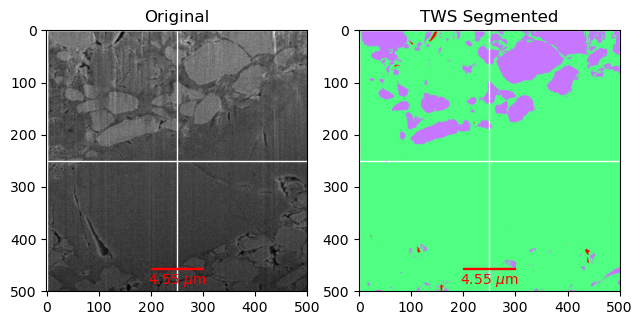

In [2]:
img = plt.imread("../unsegmented/000.tif")
img_tws = plt.imread("../segmented/000.tif")
img_tws2 = np.asarray(Image.open("../segmented/000.tif")).reshape(501, 501)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
rect0 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect1 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect2 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
rect3 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
scalebar0 = AnchoredSizeBar(ax[0].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )
scalebar1 = AnchoredSizeBar(ax[1].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )

ax[0].add_artist(scalebar0)
ax[0].add_patch(rect0)
ax[0].add_patch(rect2)
ax[0].set_title("Original")
# ax[0].axes.get_xaxis().set_visible(False)
# ax[0].axes.get_yaxis().set_visible(False)

ax[1].imshow(img_tws, cmap='gray')
ax[1].add_patch(rect1)
ax[1].add_patch(rect3)
ax[1].add_artist(scalebar1)
ax[1].set_title("TWS Segmented")
# ax[1].axes.get_xaxis().set_visible(False)
# ax[1].axes.get_yaxis().set_visible(False)
plt.savefig("../figures/tws-segmented.png", dpi=500, pad_inches=0);
plt.tight_layout();
# plt.show()

In [3]:
def neighborhood_mean(img, nx, ny):
    """
    Replace value with average of nx voxels in the +x direction and ny voxels in the +y direction for total a
    """
    img_out = np.zeros(img.shape)
    Nx, Ny = img.shape
    for i in range(Nx):
        for j in range(Ny):
            x = Nx - 1
            if i + nx < Nx:
                x = i + nx
            y = Ny - 1
            if j + ny < Ny:
                y = j + ny
            if np.isnan(np.nanmean(img[i:x, j:y])):
                # print(i, j)
                # print(np.nanmean(img[i:x, j:y]))
                img_out[i, j] = img[i, j]
            else:
                img_out[i, j] = np.nanmean(img[i:x, j:y])
    
    return img_out


def standardize_image(img, nx, ny):
    """
    Replace value with average of nx voxels in the +x direction and ny voxels in the +y direction for total a
    """
    img_out = np.zeros(img.shape)
    Nx, Ny = img.shape
    for i in range(Nx):
        for j in range(Ny):
            x = Nx - 1
            if i + nx < Nx:
                x = i + nx
            y = Ny - 1
            if j + ny < Ny:
                y = j + ny
            if not np.isnan(np.mean(img[i:x, j:y])):
                mean = np.nanmean(img[i:x, j:y])
                std = np.std(img[i:x, j:y])
                # print(mean, std)
                img_out[i, j] = (img[i, j] - mean) / std
    
    return img_out

In [4]:
# for f in sorted(os.listdir("../unsegmented")):
#     print(f)
#     if not f.endswith(".tif"):
#         continue
#     img1 = cv2.imread(f"../unsegmented/{f}", cv2.IMREAD_UNCHANGED)
#     img2 = neighborhood_mean(img1, 5, 10)
#     cv2.imwrite(f"../averaged-unsegmented/{f.strip('.tif')}.png", img2)

# Features Matrix

In [5]:
img_ = cv2.imread("../unsegmented/100.tif", cv2.IMREAD_UNCHANGED)
img_2 = filters.meijering(img_)
img_3 = neighborhood_mean(img_2, 10, 10)
img_3 = neighborhood_mean(img_3, 5, 5)
img_3 = neighborhood_mean(img_3, 5, 5)
img_3 = neighborhood_mean(img_3, 5, 5)
img = img_3 / np.max(img_3)
phases = {
    "lower_am": [0.55, 1.0],
    "lower_am_b": [0.45, 0.55],
    "lower_am_c": [0.4, 0.45],
    "se_a": [0.35, 0.4],
    "se_b": [0.325, 0.35],
    "se_c": [0.3, 0.325],
    "se_d": [0.25, 0.3],
    "se_e": [0.2, 0.25],
    "bulk_se": [0.325, 0.45],
    "top_se": [0, 0.3],
}


In [6]:
coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, 0.1)))
y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X = np.hstack((coords, y))

# Gaussian Mixture

In [7]:
n = 10
gmm = GaussianMixture(n_components=n, covariance_type="full")
y_predict = gmm.fit_predict(X)
probs = gmm.predict_proba(X)

# Bayesian Gaussian Mixture

In [8]:
n = 10
bgm = BayesianGaussianMixture(n_components=n, weight_concentration_prior_type='dirichlet_distribution', warm_start=True).fit(X)
y_predict = bgm.predict(X)

# Kernel Density Estimation

In [9]:
kde_1d = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde_1d.fit(X)
y_predict = kde_1d.sample(X.shape[0])[:, 2].reshape(-1, 1)

# DBSCAN

In [10]:
eps = 5
min_samples = 25
db = DBSCAN(eps=eps, min_samples=min_samples)
db.fit(X)
y_predict = db.fit_predict(X).reshape(-1, 1)

# HDBSCAN

In [11]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=5, gen_min_span_tree=True)
y_predict = clusterer.fit_predict(X).reshape(-1, 1)

# Clustering Results

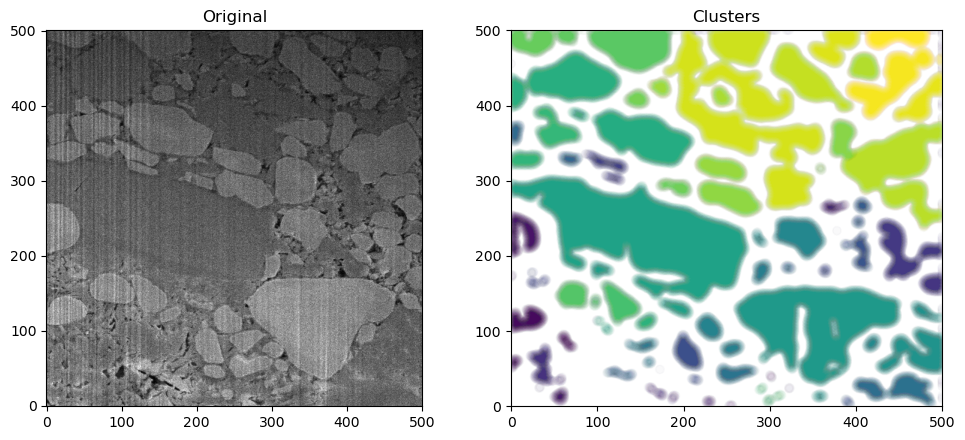

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[1].scatter(X[:, 1], X[:, 0], c=y_predict, alpha=0.01)
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

# Segmentation via Clusters

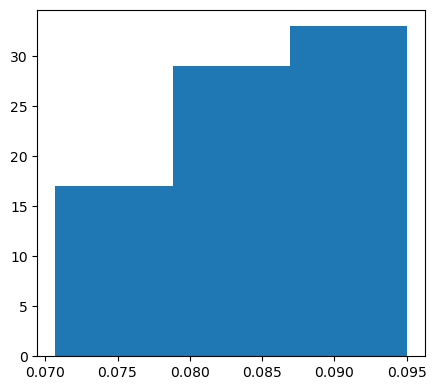

In [13]:
img_seg = -2 * np.ones(img.shape)
averages = []
fig, ax = plt.subplots(figsize=(5, 4.5))
for v in np.unique(y_predict):
    X_v = np.argwhere(y_predict == v)
    coords = list(itertools.chain.from_iterable(X_v))
    for coord in coords:
        xx, yy = X[int(coord), :2]
        img_seg[int(xx), int(yy)] = v
    px_avg = np.mean(y[X_v])
    averages.append(px_avg)
ax.hist(averages, bins=3);

# Impute Missing Values in Cluster
- Use y_predict of nearest neighbors within a given distance threshold

In [14]:
d = 7

for i in range(X.shape[0]):
    xx, yy = [int(v) for v in X[i, :2].tolist()]
    img_seg[xx, yy] = y_predict[i]

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        val = img_seg[i, j]
        if val == -2:
            neighbors = img_seg[max(i - d, 0):min(i + d, 500), max(j - d, 0):min(j + d, 500)]
            neighbors = neighbors.reshape(-1, 1).tolist()
            
            if len(neighbors) == 0:
                continue
            new_val = stats.mode(neighbors).mode[0][0]
            if new_val == -2:
                continue
            img_seg[i, j] = new_val

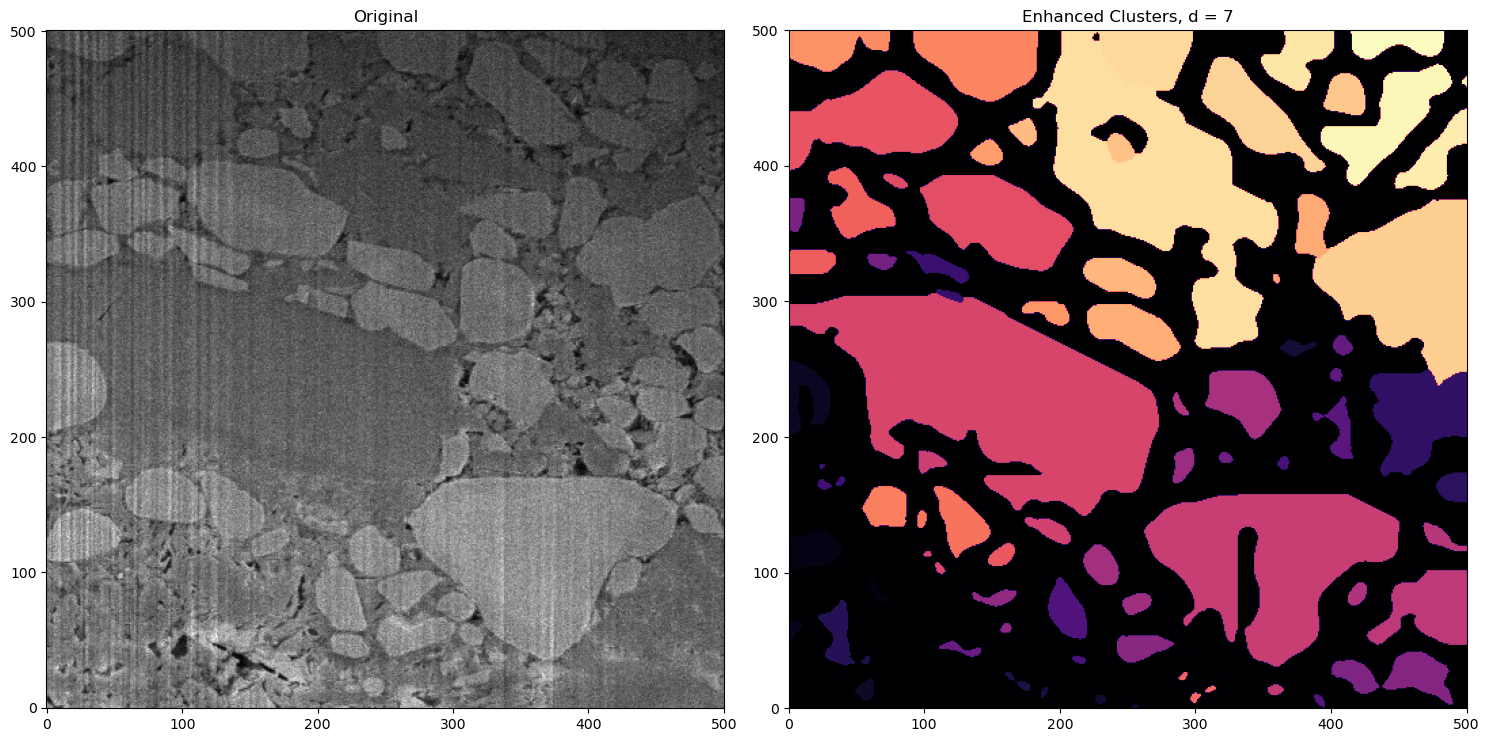

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[1].imshow(img_seg, cmap='magma')
ax[0].set_title('Original');
ax[1].set_title(f"Enhanced Clusters, d = {d}");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

In [16]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
# ax[0].imshow(img, cmap='gray')
# ax[0].invert_yaxis();
# # X_new = np.argwhere(np.isclose(img_seg, 80))
# # ax[1].scatter(X_new[:, 1], X_new[:, 0], alpha=0.1)
# # ax[1].imshow(img_seg)
# ax[0].set_title('Original');
# ax[1].set_title(f"Clusters");
# ax[1].invert_yaxis();
# ax[1].set_xlim([0, 1]);
# ax[1].set_ylim([0, 1]);
# plt.tight_layout();
# print(np.unique(img_seg), np.unique(y_predict))

# Segmentation

In [17]:
"""
0 -> void
1 -> solid electrolyte
2 -> active material
segment active material first
segment voids secondly
all that's left is SE
"""
# img_seg = np.ones(img.shape)
# clf = MLPClassifier(random_state=42, max_iter=300)


"\n0 -> void\n1 -> solid electrolyte\n2 -> active material\nsegment active material first\nsegment voids secondly\nall that's left is SE\n"

### FFT Band Pass Filter

In [18]:
# def H_lo(D, D0, n):
#     return 1 / (1 + (D/D0) ** (2 * n))


# def H_hi(D, D0, n):
#     return 1 / (1 + (D0/D) ** (2 * n))

# def fft_denoise(img, band_type='lo'):
#     """"""
#     if band_type not in ('lo', 'hi'):
#         raise ValueError("Unknown band type")
#     F = np.fft.fft2(img)
#     Fshift = np.fft.fftshift(F)
#     M, N = img.shape
#     H = np.zeros((M, N), dtype=np.float32)
#     n = 1
#     D0 = 0.75

#     for u in range(M):
#         for v in range(N):
#             D = np.sqrt((u - M/2) ** 2 + (v - N/2) ** 2)
#             if band_type == 'hi':
#                 H[u, v] = H_hi(D, D0, n)
#             else:
#                 H[u, v] = H_lo(D, D0, n)

#     Gshift = Fshift * H
#     G = np.fft.ifftshift(Gshift)
#     g = np.abs(np.fft.ifft2(G)) * 255
    
#     return g

# g = fft_denoise(img_, 'hi')
# D0 = 0.75
# fig, ax = plt.subplots(1, 2, figsize=(15, 15))
# ax[0].imshow(img, cmap="gray")
# rect = patches.Rectangle((150, 350), 50, 50, edgecolor='r', fill=False)
# ax[0].add_patch(rect)
# ax[0].set_title("Original")
# ax[1].imshow(g, cmap="gray")
# rect1 = patches.Rectangle((150, 350), 50, 50, edgecolor='r', fill=False)
# ax[1].add_patch(rect1)
# ax[1].set_title(f"Filtered, cut off freq = {D0}")
# plt.imsave("../figures/fft-hi-unsegmented.bmp", g, cmap='gray', format="bmp")
# plt.show()

### Identification of Clusters

In [19]:
points = set()
for (x, y) in np.argwhere(img_seg):
    points.add((x, y))
point_ids = np.zeros((len(points), 2))
for idx, point in enumerate(points):
    point_ids[idx, :] = point
points_view = {(v[0], int(v[1])): k for k, v in enumerate(point_ids)}

G = nx.Graph()
for k, v in points_view.items():
    G.add_node(v)
for k in points_view.keys():
    x, y = k
    neighbors = [
        (int(x + 1), y),
        (int(x - 1), y),
        (x, int(y + 1)),
        (x, int(y - 1)),
        (int(x + 1), int(y + 1)),
    ]
    p0 = points_view[k]
    for neighbor in neighbors:
        p = points_view.get(neighbor)
        if p is None:
            continue
        G.add_edge(p0, p)
pieces = nx.connected_components(G)
pieces = [piece for piece in pieces]